In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import os
from os.path import isfile, join, splitext
import random
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True

from process_raw_prices import *


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# # make sure the jupyter notebook run in this working directory
# %cd ~/fyp/code/model

In [3]:
tf.enable_eager_execution()

In [4]:
num_of_pair = 6670

In [5]:
# processed dataset folder path
dataset_folder_path = '../../dataset/nyse-daily-transformed'
os.makedirs(dataset_folder_path, exist_ok=True)

# raw dataset files pattern
raw_files_path_pattern = "../../dataset/nyse-daily-trimmed-same-length/*.csv"

df_columns = ['close1', 'close2', 'normalizedLogClose1', 'normalizedLogClose2', 'spread', 'alpha', 'beta']
ind = {'y_close': 0, 'x_close': 1, 'spread': 4}

# compute dataset
all_pairs_slices = [splitext(f)[0] for f in os.listdir(dataset_folder_path) if isfile(join(dataset_folder_path, f))]
if len(all_pairs_slices) == 0:
    generate_pairs_training_data(raw_files_path_pattern=raw_files_path_pattern,
                                 result_path=dataset_folder_path,
                                 min_size=252*4,
                                 training_period=52,
                                 points_per_cut=252
                                )
    all_pairs_slices = [splitext(f)[0] for f in os.listdir(dataset_folder_path) if isfile(join(dataset_folder_path, f))]
print("Total number of pair slices: %d" % len(all_pairs_slices))

# split for training and testing
all_pairs = sorted(list(set(['-'.join(p.split('-')[0:2]) for p in all_pairs_slices])))[:num_of_pair]
# all_pairs = ["VMW-WUBA"]
# all_pairs = ["TWTR-UIS"]
all_pairs_slices_train = []
all_pairs_slices_valid = []
all_pairs_slices_test = []
for p in all_pairs:
    all_pairs_slices_train += [p+'-0']
    all_pairs_slices_valid += [p+'-1']
    all_pairs_slices_test += [p+'-2']
    # note that we also have 3 that can use
print("Total number of pair slices for training: %d" % len(all_pairs_slices_train))
print("Total number of pair slices for validation: %d" % len(all_pairs_slices_valid))
print("Total number of pair slices for testing: %d" % len(all_pairs_slices_test))

start_t = time.time()
all_pairs_df = {}
for s in all_pairs_slices_train:
    all_pairs_df[s] = pd.read_csv(join(dataset_folder_path, s+".csv"))
for s in all_pairs_slices_valid:
    all_pairs_df[s] = pd.read_csv(join(dataset_folder_path, s+".csv"))
for s in all_pairs_slices_test:
    all_pairs_df[s] = pd.read_csv(join(dataset_folder_path, s+".csv"))
print('time spent for loading df = {}s'.format(time.time()-start_t))

Total number of pair slices: 26680
Total number of pair slices for training: 6670
Total number of pair slices for validation: 6670
Total number of pair slices for testing: 6670
time spent for loading df = 51.31767797470093s


In [6]:
# update batch size
batch_size = 300

# number of batch in training
num_of_epoch = 75
num_of_batch = 2*num_of_pair*num_of_epoch//batch_size

# fixed number of time steps in one episode (not used)
trading_period = 200

# # 1 is zscore
# num_features = 1

# 0 is no position. 1 is long the spread. 2 is short the spread.
a_num = position_num = 3

# RNN hidden state dimension
h_dim = 30

# number of RNN layer
num_layers = 1

# number of layer1 output
layer1_out_num = 10

# learning rate
lr = 5e-4

reg = 0.0001

# discount factor in reinforcement learning
gamma = 1

# random action probability lower is better...
rand_action_prob = 0.0

batches_per_print = 10*5
bins_num = 30

# dummy initial cash
initial_cash = 10000

# checkpoint folder
checkpoint_dir = '../../model_checkpoint/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [7]:
# functions

# glob_mode should be assigned to None if an epoch finished
glob_mode = None
sample_start_index = None
curr_pairs = None
def get_random_history(batch_size, mode):
    """Sample some pairs and get the history of those pairs. The history should have
    three dimension. The first dimension is for time. The second dimension is indexed
    by features name. The third dimension is the index of training instance.
    """
    global glob_mode
    global sample_start_index
    global curr_pairs
    
    if mode == 'train': # user intended to use training data
        # first batch of training data
        # shuffle the data first before sampling
        if glob_mode != 'train':
            glob_mode = 'train'
            random.shuffle(all_pairs_slices_train)
            sample_start_index = 0
        sample_end_index = sample_start_index+batch_size
        sample_pair_slices = all_pairs_slices_train[sample_start_index:sample_end_index]

        # end of one epoch
        if sample_end_index >= len(all_pairs_slices_train):
            glob_mode = None

    elif mode == 'valid': # user intended to use validation data
        # first batch of validation data
        # shuffle the data first before sampling
        if glob_mode != 'valid':
            glob_mode = 'valid'
            random.shuffle(all_pairs_slices_valid)
            sample_start_index = 0
        sample_end_index = sample_start_index+batch_size
        sample_pair_slices = all_pairs_slices_valid[sample_start_index:sample_end_index]

        # end of one epoch
        if sample_end_index >= len(all_pairs_slices_valid):
            glob_mode = None
    elif mode == 'test': # user intended to use validation data
        # first batch of test data
        # shuffle the data first before sampling
        if glob_mode != 'test':
            glob_mode = 'test'
            random.shuffle(all_pairs_slices_test)
            sample_start_index = 0
        sample_end_index = sample_start_index+batch_size
        sample_pair_slices = all_pairs_slices_test[sample_start_index:sample_end_index]

        # end of one epoch
        if sample_end_index >= len(all_pairs_slices_test):
            glob_mode = None
    else:
        raise Exception("mode should be in ['train', 'valid', 'test'].")
    
    curr_pairs = sample_pair_slices
    
    # update index for next batch
    sample_start_index += batch_size
    
    # return to the environment. this should be no greater than batch_size
    actual_batch_size = len(sample_pair_slices)
    
    history = []
    for s in sample_pair_slices:
#         df = pd.read_csv(join(dataset_folder_path, s+".csv"))
        df = all_pairs_df[s]
        df_val = df[df_columns].values
        history.append(df_val)
    
    history = np.array(history)
    return np.transpose(history, (1, 2, 0)), actual_batch_size

def compute_input_history(history):
    """Slicing history in its second dimension."""
    # no slicing for now
    return history[:,2:]

def sample_action(logits, random=False, batch_size=batch_size):
    if random:
        dist = tf.distributions.Categorical(logits=tf.zeros([batch_size, a_num]))
    else:
        dist = tf.distributions.Categorical(logits=logits)
    
    # 1-D Tensor where the i-th element correspond to a sample from
    # the i-th categorical distribution
    return dist.sample()

def long_portfolio_value(q, p):
    return q*p

def short_portfolio_value(q, p, init_p):
    return q*(3.0*init_p/2 - p)

# def discount_rewards(r, all_actions):
#     """
#     r is a numpy array in the shape of (n, batch_size).
#     all_actions is a numpy array in the same shape as r.
    
#     return the discounted and cumulative rewards"""
    
#     result = np.zeros_like(r, dtype=float)
#     n = r.shape[0]
#     sum_ = np.zeros_like(r[0], dtype=float)
#     pre_action = all_actions[n-1]
#     for i in range(n-1,-1,-1):
#         sum_ *= gamma
        
#         # when the previous action(position) not equal to the current one,
#         # set the previous sum of reward to be zero.
#         sum_ = sum_*(all_actions[i]==pre_action) + r[i]
#         result[i] = sum_
        
#         # update pre_action
#         pre_action = all_actions[i]
    
#     return result

def discount_rewards(r):
    """
    r is a numpy array in the shape of (n, batch_size).
    
    return the discounted and cumulative rewards"""
    
    result = np.zeros_like(r, dtype=float)
    n = r.shape[0]
    sum_ = np.zeros_like(r[0], dtype=float)
    for i in range(n-1,-1,-1):
        sum_ *= gamma
        sum_ += r[i]
        result[i] = sum_
    
    return result

def loss(all_logits, all_actions, all_advantages):
    neg_log_select_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_logits, labels=all_actions)
    
    # 0 axis is the time axis. 1 axis is the batch axis
    return tf.reduce_mean(neg_log_select_prob * all_advantages, 0)

def extract_pair_name(s):
    return '_'.join(s.split('-')[:2])

def extract_pair_index(s):
    return int(s.split('-')[-1])

def save_model():
    hkg_time = datetime.now() + timedelta(hours=16)
    checkpoint_name = hkg_time.strftime("%Y%m%d_%H%M%S")
    checkpoint_prefix = os.path.join(checkpoint_dir, checkpoint_name)
    root.save(checkpoint_prefix)
    tf.train.latest_checkpoint(checkpoint_dir)
    
def restore_model(checkpoint_name):
    root.restore(join(checkpoint_dir, checkpoint_name))


myLeakyReLU = tf.keras.layers.LeakyReLU()
myLeakyReLU.__name__ = "myLeakyReLU"

# classes
class TradingPolicyModel(tf.keras.Model):
    def __init__(self):
        super(TradingPolicyModel, self).__init__()
        self.dense1 = tf.layers.Dense(units=layer1_out_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )
        self.dense2 = tf.layers.Dense(units=layer1_out_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )
        self.dense3 = tf.layers.Dense(units=layer1_out_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )
#         self.dense4 = tf.layers.Dense(units=layer1_out_num,
#                                       activation=tf.keras.layers.LeakyReLU(),
#                                       kernel_initializer=tf.contrib.layers.xavier_initializer()
#                                      )
        self.logits = tf.layers.Dense(units=a_num,
                                      activation=myLeakyReLU,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(reg)
                                     )

    def call(self, inputs):
        # Forward pass
        inputs = self.dense1(inputs)
        inputs = self.dense2(inputs)
        inputs = self.dense3(inputs)
#         inputs = self.dense4(inputs)
        logits = self.logits(inputs)
        return logits


class StateEncodingModel(tf.keras.Model):
    def __init__(self, batch_size=batch_size):
        super(StateEncodingModel, self).__init__()
        self.cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(h_dim) for i in range(num_layers)])
        self.reset_state(batch_size)
    
    def call(self, inputs):
        output, self.state = self.cell(inputs, self.state)
        return output
        
    def reset_state(self, batch_size=batch_size):
        self.state = self.cell.zero_state(batch_size, tf.float32)


class TradingEnvironment():
    """Trading environment for reinforcement learning training.
    
    NOTE: Call reset first before calling step!
    
    Arguments:
        state_encoding_model: the model that encode past input_history data into a state
        vector which will be fed as input to the policy network.
    """
    def __init__(self, state_encoding_model):
        # do some initialization
        self.state_encoding_model = state_encoding_model
        
    def _reset_env(self, mode, batch_size=batch_size):
        
        # prepare a batch of history and input_history
        # actual batch_size depends on the dataset
        self.history, curr_batch_size = get_random_history(batch_size, mode)
        batch_size = curr_batch_size
        self.input_history = compute_input_history(self.history)
        
        self.t = 0
        self.state_encoding_model.reset_state(batch_size)

        # 0 is no position. 1 is long the spread. 2 is short the spread
        self.position = np.zeros(batch_size, dtype=int)
        
        # initialize the cash each agent has
        self.total_portfolio_value = np.ones(batch_size)*initial_cash
        
        # only useful when there is a postion on the spread
        self.quantity = {'x': np.zeros(batch_size), 'y': np.zeros(batch_size)}
        
        # for compute current portfolio value of the short side
        self.short_side_init_price = np.zeros(batch_size)
        
        # create or update self.state variable
        self.update_state()
    
    def reset(self, mode):
        """Return an initial state for the trading environment"""
        
        # determine what dataset to use
        self._reset_env(mode)
        return self.state
    
    def compute_reward(self, action):
        """Compute the reward at time t which is the change in total portfolio value
        from time t to t+1. It also update the position for time t+1. Exit trade when
        the short side portfolio value <= 0."""
        
        r = np.zeros_like(action, dtype=float)
        cur_his = self.history[self.t]
        nex_his = self.history[self.t+1]
        
        # compute for each training instance in a batch
        for i, a in enumerate(action):
            y_p = cur_his[ind["y_close"], i]
            x_p = cur_his[ind["x_close"], i]
            nex_y_p = nex_his[ind["y_close"], i]
            nex_x_p = nex_his[ind["x_close"], i]
            
            
            if a == 0: # take no position on the spread
                # no change in portfolio value
                r[i] = 0
                self.position[i] = 0
                self.quantity['y'][i] = 0.0
                self.quantity['x'][i] = 0.0
            elif a == 1: # long the spread: long Y and short X
                # quantity of each stock will change when the current position is not previous position
                if self.position[i] == 0 or self.position[i] == 2:
                    # compute quantity from cash
                    self.quantity['y'][i] = 2.0*self.total_portfolio_value[i]/3.0/y_p
                    self.quantity['x'][i] = 2.0*self.total_portfolio_value[i]/3.0/x_p
                    self.short_side_init_price[i] = x_p

                lpv = long_portfolio_value(self.quantity['y'][i], nex_y_p)
                spv = short_portfolio_value(self.quantity['x'][i], nex_x_p, self.short_side_init_price[i])
                
                # the zero here can be changed to other positive threshold ...
                if spv <= 0:
                    # we loss all the money in the short side
                    nex_portfolio_value = lpv

                    # forced to take position 0
                    self.position[i] = 0
                else:
                    nex_portfolio_value = lpv + spv
                    self.position[i] = 1
                
                r[i] = nex_portfolio_value - self.total_portfolio_value[i]
                self.total_portfolio_value[i] = nex_portfolio_value
            elif a == 2: # short the spread: short Y and long X
                # quantity will change when the current position is not previous position
                if self.position[i] == 0 or self.position[i] == 1:
                    # compute quantity from cash
                    self.quantity['y'][i] = 2.0*self.total_portfolio_value[i]/3.0/y_p
                    self.quantity['x'][i] = 2.0*self.total_portfolio_value[i]/3.0/x_p
                    self.short_side_init_price[i] = y_p

                lpv = long_portfolio_value(self.quantity['x'][i], nex_x_p)
                spv = short_portfolio_value(self.quantity['y'][i], nex_y_p, self.short_side_init_price[i])
                
                if spv <= 0:
                    # we loss all the money in the short side
                    nex_portfolio_value = lpv

                    # forced to take position 0
                    self.position[i] = 0
                else:
                    nex_portfolio_value = lpv + spv
                    self.position[i] = 2
                
                r[i] = nex_portfolio_value - self.total_portfolio_value[i]
                self.total_portfolio_value[i] = nex_portfolio_value
        return r
    
    def update_state(self):
#         # concate next_input_history and next position to form next partial state
#         partial_state = tf.concat([self.input_history[self.t].T, tf.one_hot(self.position, position_num)], 1)
        
#         # update state
#         self.state = self.state_encoding_model(partial_state)

        observation = tf.convert_to_tensor(self.input_history[self.t].T, dtype=tf.float32)
    
        # use rnn to encode observationans and current stock state into next stock state
        stock_state = self.state_encoding_model(observation)
        
        # do normalization for total_portfolio_value
        # this is extremely important. if not normalized, the action will be highly biased.
        portfolio_state = np.array([
            self.total_portfolio_value/initial_cash,
#             self.quantity['y'],
#             self.quantity['x']
        ]).T
        
        # stock state and portfolio state together form the whole environment state
        self.state = tf.concat([
            stock_state,
            portfolio_state,
            tf.one_hot(self.position, position_num)
        ], 1)
    
    def step(self, action):
        """Given the current state and action, return the reward, next state and done.
        This function should be called after reset.
        
        reward is of type numpy array. state is of type tensor. done is of type boolean.
        
        
        Arguments:
            action: a numpy array containing the current action for each training pair.

        Note that we follow the convention where the trajectory is indexed as s_0, a_0, r_0,
        s_1, ... . Therefore t is updated just after computing the reward is computed and
        before computing next state.
        """
        # r_t
        r = self.compute_reward(action) # also update the position for time t+1

        # t = t+1
        self.t += 1
        
        # compute s_(t+1)
        self.update_state()

        return r, self.state, (self.t+1) == trading_period

In [8]:
# create objects
pi = TradingPolicyModel()
state_encoding_model = StateEncodingModel()
env = TradingEnvironment(state_encoding_model)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# create checkpoint object
root = tf.train.Checkpoint(pi=pi, state_encoding_model=state_encoding_model, optimizer=optimizer)

In [9]:
def run_batch_for_evaluate_performance(reward_list, mode):
    done = False
    s = env.reset(mode)
#     print('s:', s)

    # for accumalting episode statistics
    act_batch_size = tf.shape(s).numpy()[0]
    total_r = np.zeros(act_batch_size)

    # internally the episode length is fixed by trading_period
    while not done:
        logits = pi(s)
        a = sample_action(logits, batch_size=act_batch_size)

        # get immediate reward, update state, and get done
        r, s, done = env.step(a.numpy())

#         # for debugging
#         print('logits:', logits)
#         print('a:', a.numpy())
#         print('r:', r)
#         print('s:', s)

        total_r += r
    reward_list += total_r.tolist()
    return {extract_pair_name(curr_pairs[i]): total_r[i] for i in range(act_batch_size)}


def run_epoch_for_evaluate_performance(rs, total_r_dict, mode):
    counter = 0
    temp_dict = run_batch_for_evaluate_performance(rs, mode)
    total_r_dict.update(temp_dict)
    print('{}, '.format(counter), end='')
    counter += 1
    while glob_mode != None:
        temp_dict = run_batch_for_evaluate_performance(rs, mode)
        total_r_dict.update(temp_dict)
        print('{}, '.format(counter), end='')
        counter += 1

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 6670
8.571268993891799


(array([5.000e+00, 2.300e+01, 7.500e+01, 1.810e+02, 3.170e+02, 5.530e+02,
        8.200e+02, 1.036e+03, 1.012e+03, 8.460e+02, 6.550e+02, 4.060e+02,
        2.630e+02, 1.530e+02, 1.070e+02, 7.100e+01, 4.400e+01, 4.000e+01,
        1.600e+01, 1.100e+01, 1.200e+01, 8.000e+00, 6.000e+00, 5.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-7446.27438343, -6579.44178691, -5712.60919039, -4845.77659387,
        -3978.94399735, -3112.11140083, -2245.27880431, -1378.44620779,
         -511.61361128,   355.21898524,  1222.05158176,  2088.88417828,
         2955.7167748 ,  3822.54937132,  4689.38196784,  5556.21456436,
         6423.04716088,  7289.8797574 ,  8156.71235391,  9023.54495043,
         9890.37754695, 10757.21014347, 11624.04273999, 12490.87533651,
        13357.70793303, 14224.54052955, 15091.37312607, 15958.20572259,
        16825.03831911, 17691.87091562, 18558.70351214]),
 <a list of 30 Patch objects>)

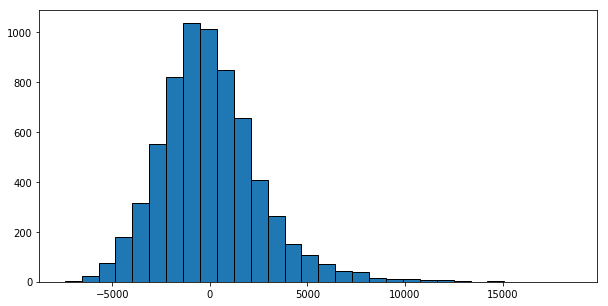

In [10]:
# evaluate performance on train dataset
train_rs = []
train_total_r_dict = {}
run_epoch_for_evaluate_performance(train_rs, train_total_r_dict, 'train')

print(len(train_rs))
print(np.mean(train_rs))
plt.gcf().set_size_inches(10, 5)
plt.hist(train_rs, bins=bins_num)


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 6670
-71.93802729684194


(array([2.000e+00, 2.100e+01, 7.100e+01, 2.180e+02, 4.700e+02, 8.540e+02,
        1.189e+03, 1.266e+03, 1.009e+03, 6.120e+02, 3.930e+02, 2.430e+02,
        1.520e+02, 6.800e+01, 3.500e+01, 3.400e+01, 1.200e+01, 7.000e+00,
        7.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-7540.67784414, -6559.42282129, -5578.16779844, -4596.9127756 ,
        -3615.65775275, -2634.4027299 , -1653.14770705,  -671.89268421,
          309.36233864,  1290.61736149,  2271.87238434,  3253.12740718,
         4234.38243003,  5215.63745288,  6196.89247573,  7178.14749857,
         8159.40252142,  9140.65754427, 10121.91256712, 11103.16758997,
        12084.42261281, 13065.67763566, 14046.93265851, 15028.18768136,
        16009.4427042 , 16990.69772705, 17971.9527499 , 18953.20777275,
        19934.46279559, 20915.71781844, 21896.97284129]),
 <a list of 30 Patch objects>)

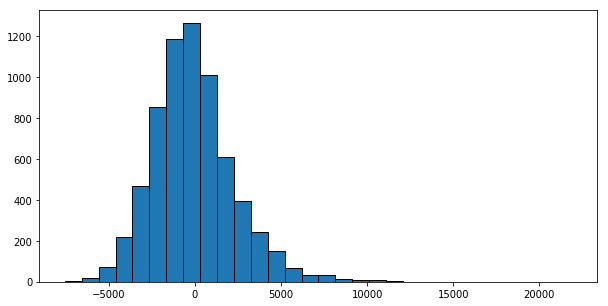

In [11]:
# evaluate performance on valid dataset
valid_rs = []
valid_total_r_dict = {}
run_epoch_for_evaluate_performance(valid_rs, valid_total_r_dict, 'valid')

print(len(valid_rs))
print(np.mean(valid_rs))
plt.gcf().set_size_inches(10, 5)
plt.hist(valid_rs, bins=bins_num)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 6670
-12.47574217703481


(array([1.000e+01, 2.300e+01, 9.600e+01, 2.100e+02, 4.380e+02, 6.810e+02,
        1.047e+03, 1.148e+03, 1.054e+03, 7.250e+02, 4.690e+02, 3.040e+02,
        1.820e+02, 9.900e+01, 5.700e+01, 4.200e+01, 3.600e+01, 1.900e+01,
        8.000e+00, 8.000e+00, 5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-6710.49501686, -5868.44101565, -5026.38701445, -4184.33301325,
        -3342.27901205, -2500.22501084, -1658.17100964,  -816.11700844,
           25.93699277,   867.99099397,  1710.04499517,  2552.09899638,
         3394.15299758,  4236.20699878,  5078.26099999,  5920.31500119,
         6762.36900239,  7604.4230036 ,  8446.4770048 ,  9288.531006  ,
        10130.58500721, 10972.63900841, 11814.69300961, 12656.74701082,
        13498.80101202, 14340.85501322, 15182.90901442, 16024.96301563,
        16867.01701683, 17709.07101803, 18551.12501924]),
 <a list of 30 Patch objects>)

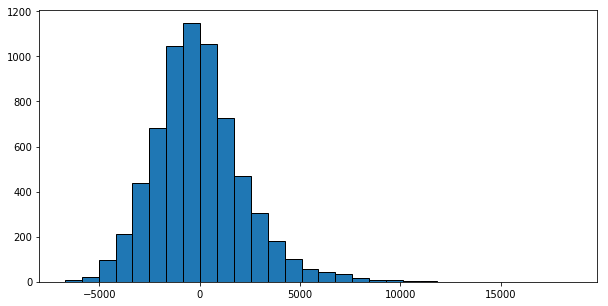

In [12]:
# evaluate performance on test dataset
test_rs = []
test_total_r_dict = {}
run_epoch_for_evaluate_performance(test_rs, test_total_r_dict, 'test')

print(len(test_rs))
print(np.mean(test_rs))
plt.gcf().set_size_inches(10, 5)
plt.hist(test_rs, bins=bins_num)

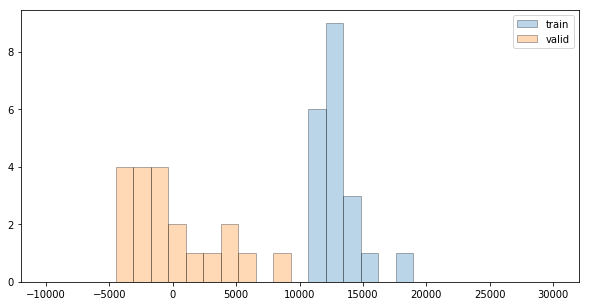

In [13]:
# pick best K pairs from train result and see how good those pairs are in valid
K = 20
train_total_r_ordered = sorted(list(train_total_r_dict.items()), key=lambda x: x[1], reverse=True)
train_total_r_ordered_sliced = train_total_r_ordered[:K]
valid_total_r_sliced = [(x[0], valid_total_r_dict[x[0]]) for x in train_total_r_ordered_sliced]
valid_total_r_corresponding_value = [x[1] for x in valid_total_r_sliced]
train_total_r_sliced_value = [x[1] for x in train_total_r_ordered_sliced]

# see if the model overfits a lot by checking the performace in valid of best K pairs in train
bins = np.linspace(-10000, 30000, 30)
plt.hist(train_total_r_sliced_value, bins, alpha=0.3, label='train')
plt.hist(valid_total_r_corresponding_value, bins, alpha=0.3, label='valid')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)

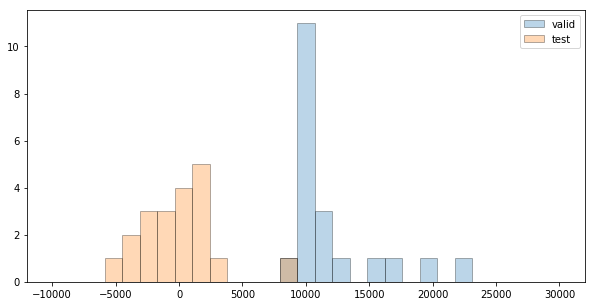

In [14]:
# pick best K pairs from valid result and see how good those pairs are in test
K = 20
valid_total_r_ordered = sorted(list(valid_total_r_dict.items()), key=lambda x: x[1], reverse=True)
valid_total_r_ordered_sliced = valid_total_r_ordered[:K]
test_total_r_sliced = [(x[0], test_total_r_dict[x[0]]) for x in valid_total_r_ordered_sliced]
test_total_r_corresponding_value = [x[1] for x in test_total_r_sliced]
valid_total_r_sliced_value = [x[1] for x in valid_total_r_ordered_sliced]

# see if the model overfits a lot by checking the performace in valid of best K pairs in train
bins = np.linspace(-10000, 30000, 30)
plt.hist(valid_total_r_sliced_value, bins, alpha=0.3, label='valid')
plt.hist(test_total_r_corresponding_value, bins, alpha=0.3, label='test')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)

In [15]:
# print parameters
print('num_of_pair =', num_of_pair)
print('batch_size =', batch_size)
print('num_of_batch = {}, estimated epoch = {}'.format(num_of_batch, num_of_batch*batch_size/2/num_of_pair))
print('rand_action_prob =', rand_action_prob)
print('lr =', lr)

# for training reference only
average_total_r = 0.0
epoch_average_total_r = 0.0
num_eps_over = 0
total_r_dict = {}

start_time = time.time()
for batch in range(num_of_batch):
    
    with tf.GradientTape() as gt:
        # saving for update
        all_logits = []
        all_actions = []
        all_rewards = []
        
        # episode starts here~
        done = False
        s = env.reset('train')
        
        # for accumalting episode statistics
        act_batch_size = tf.shape(s).numpy()[0]
        num_eps_over += act_batch_size
        total_r = np.zeros(act_batch_size)

        # internally the episode length is fixed by trading_period
        while not done:
            logits = pi(s)
            a = sample_action(logits, random=np.random.rand() <= rand_action_prob,
                              batch_size=act_batch_size)
            r, s, done = env.step(a.numpy())

            # save the episode
            all_logits.append(logits)
            all_actions.append(a)
            all_rewards.append(r)
            
            r_sum = np.sum(r)
            average_total_r += r_sum
            epoch_average_total_r += r_sum
            total_r += r
            
#             # debugging
#             print(env.t)
#             print(env.t+1==200)
#             print(r[0])
#             print('a:', a.numpy())
#             print(env.total_portfolio_value[0])
#             print(done)
#             print(logits)

        # keep track of the pair performance (of course this is not totally fair for all pairs
        # as there are parameters update).
        total_r_dict.update({curr_pairs[i]: total_r[i] for i in range(act_batch_size)})

        all_logits_stack = tf.stack(all_logits)
        all_actions_stack = tf.stack(all_actions)
        all_rewards_stack = np.array(all_rewards)
        
        # compute cummulative rewards for each action
        all_cum_rewards = discount_rewards(all_rewards_stack)
#         all_cum_rewards -= np.mean(all_cum_rewards)
#         all_cum_rewards /= np.std(all_cum_rewards)
#         all_cum_rewards /= np.mean(np.abs(all_cum_rewards))
        all_cum_rewards /= initial_cash
        all_cum_rewards = tf.convert_to_tensor(all_cum_rewards, dtype=tf.float32)

        loss_value = loss(all_logits_stack, all_actions_stack, all_cum_rewards)
    
    grads = gt.gradient(loss_value, state_encoding_model.variables + pi.variables)
    optimizer.apply_gradients(zip(grads, state_encoding_model.variables + pi.variables))
    
    if (batch+1) % batches_per_print == 0:
        end_time = time.time()
        print(("batch_id: {}, num_eps_over: {}, average_total_r_per_ep: {:.2f}, "+
               "time_spent: {:.1f}s").format(
            batch, num_eps_over, average_total_r/num_eps_over, end_time-start_time))
        
        # reset
        average_total_r = 0.0
        num_eps_over = 0
        start_time = time.time()
    
    # print epoch summary
    if glob_mode == None:
        # compute average total reward in one epoch to evaluate agent performance
        print("average total_r over one epoch: {:.2f}".format(
            epoch_average_total_r/len(total_r_dict)))
        
        # reset
        epoch_average_total_r = 0.0
        total_r_dict = {}
        
print('Finished training~')

num_of_pair = 6670
batch_size = 300
num_of_batch = 3335, estimated epoch = 75.0
rand_action_prob = 0.0
lr = 0.0005
average total_r over one epoch: 51.25
average total_r over one epoch: 129.25
batch_id: 49, num_eps_over: 14540, average_total_r_per_ep: 102.96, time_spent: 68.9s
average total_r over one epoch: 204.19
average total_r over one epoch: 325.32
batch_id: 99, num_eps_over: 14540, average_total_r_per_ep: 309.73, time_spent: 66.5s
average total_r over one epoch: 588.70
average total_r over one epoch: 1020.62
batch_id: 149, num_eps_over: 14540, average_total_r_per_ep: 942.72, time_spent: 65.8s
average total_r over one epoch: 1209.04
average total_r over one epoch: 1353.93
batch_id: 199, num_eps_over: 14540, average_total_r_per_ep: 1353.19, time_spent: 66.9s
average total_r over one epoch: 1413.08
average total_r over one epoch: 1458.22
batch_id: 249, num_eps_over: 14540, average_total_r_per_ep: 1471.08, time_spent: 66.5s
average total_r over one epoch: 1518.86
average total_r over 

batch_id: 2349, num_eps_over: 14540, average_total_r_per_ep: 2745.17, time_spent: 66.8s
average total_r over one epoch: 2713.83
average total_r over one epoch: 2727.13
batch_id: 2399, num_eps_over: 14540, average_total_r_per_ep: 2700.04, time_spent: 66.5s
average total_r over one epoch: 2665.46
average total_r over one epoch: 2749.98
batch_id: 2449, num_eps_over: 14540, average_total_r_per_ep: 2724.81, time_spent: 66.5s
average total_r over one epoch: 2786.74
average total_r over one epoch: 2823.46
batch_id: 2499, num_eps_over: 14540, average_total_r_per_ep: 2790.42, time_spent: 66.9s
average total_r over one epoch: 2779.54
average total_r over one epoch: 2773.38
batch_id: 2549, num_eps_over: 14540, average_total_r_per_ep: 2803.33, time_spent: 68.7s
average total_r over one epoch: 2815.76
average total_r over one epoch: 2825.32
average total_r over one epoch: 2834.62
batch_id: 2599, num_eps_over: 14310, average_total_r_per_ep: 2828.57, time_spent: 66.4s
average total_r over one epoch: 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 6670
2811.520542220355


(array([6.000e+00, 1.900e+01, 9.900e+01, 2.860e+02, 7.830e+02, 1.243e+03,
        1.311e+03, 9.520e+02, 6.330e+02, 4.330e+02, 2.600e+02, 1.900e+02,
        1.460e+02, 9.400e+01, 7.000e+01, 4.600e+01, 2.800e+01, 2.300e+01,
        1.400e+01, 8.000e+00, 5.000e+00, 5.000e+00, 7.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-5410.24558871, -4276.2411588 , -3142.2367289 , -2008.23229899,
         -874.22786909,   259.77656082,  1393.78099072,  2527.78542063,
         3661.78985053,  4795.79428044,  5929.79871034,  7063.80314025,
         8197.80757015,  9331.81200006, 10465.81642996, 11599.82085987,
        12733.82528977, 13867.82971968, 15001.83414958, 16135.83857949,
        17269.84300939, 18403.8474393 , 19537.8518692 , 20671.85629911,
        21805.86072901, 22939.86515892, 24073.86958883, 25207.87401873,
        26341.87844864, 27475.88287854, 28609.88730845]),
 <a list of 30 Patch objects>)

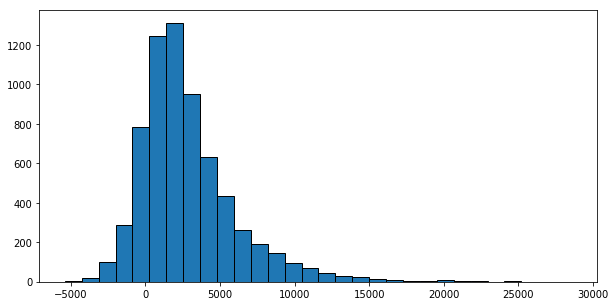

In [16]:
# evaluate performance on train dataset
glob_mode = None # reset the dataset
train_rs = []
train_total_r_dict = {}
run_epoch_for_evaluate_performance(train_rs, train_total_r_dict, 'train')

print(len(train_rs))
print(np.mean(train_rs))
plt.gcf().set_size_inches(10, 5)
plt.hist(train_rs, bins=bins_num)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 6670
2683.558319466849


(array([1.500e+01, 7.100e+01, 2.030e+02, 4.840e+02, 8.670e+02, 1.194e+03,
        1.237e+03, 9.730e+02, 6.250e+02, 3.780e+02, 2.280e+02, 1.430e+02,
        8.900e+01, 5.700e+01, 4.000e+01, 2.400e+01, 1.400e+01, 1.100e+01,
        7.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-5562.27700161, -4330.56179333, -3098.84658506, -1867.13137679,
         -635.41616851,   596.29903976,  1828.01424803,  3059.72945631,
         4291.44466458,  5523.15987285,  6754.87508113,  7986.5902894 ,
         9218.30549767, 10450.02070594, 11681.73591422, 12913.45112249,
        14145.16633076, 15376.88153904, 16608.59674731, 17840.31195558,
        19072.02716386, 20303.74237213, 21535.4575804 , 22767.17278868,
        23998.88799695, 25230.60320522, 26462.31841349, 27694.03362177,
        28925.74883004, 30157.46403831, 31389.17924659]),
 <a list of 30 Patch objects>)

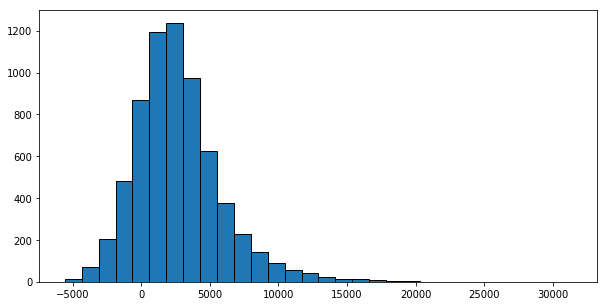

In [17]:
# evaluate performance on valid dataset
valid_rs = []
valid_total_r_dict = {}
run_epoch_for_evaluate_performance(valid_rs, valid_total_r_dict, 'valid')

print(len(valid_rs))
print(np.mean(valid_rs))
plt.gcf().set_size_inches(10, 5)
plt.hist(valid_rs, bins=bins_num)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 6670
2216.850133460629


(array([1.000e+00, 6.000e+00, 1.600e+01, 4.500e+01, 9.100e+01, 1.670e+02,
        2.950e+02, 4.690e+02, 7.640e+02, 1.014e+03, 9.740e+02, 8.280e+02,
        6.640e+02, 4.160e+02, 2.730e+02, 2.000e+02, 1.480e+02, 9.600e+01,
        7.400e+01, 4.100e+01, 2.400e+01, 2.000e+01, 1.300e+01, 1.000e+01,
        7.000e+00, 7.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([-7212.03149656, -6339.95024104, -5467.86898551, -4595.78772998,
        -3723.70647445, -2851.62521893, -1979.5439634 , -1107.46270787,
         -235.38145234,   636.69980319,  1508.78105871,  2380.86231424,
         3252.94356977,  4125.0248253 ,  4997.10608083,  5869.18733635,
         6741.26859188,  7613.34984741,  8485.43110294,  9357.51235847,
        10229.59361399, 11101.67486952, 11973.75612505, 12845.83738058,
        13717.9186361 , 14589.99989163, 15462.08114716, 16334.16240269,
        17206.24365822, 18078.32491374, 18950.40616927]),
 <a list of 30 Patch objects>)

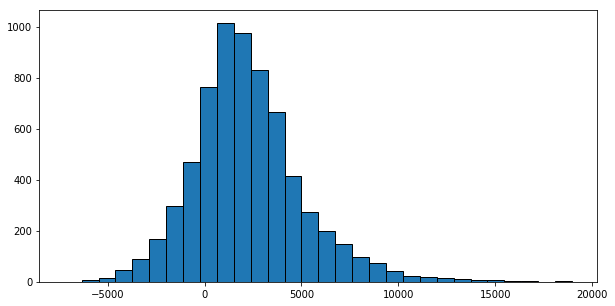

In [18]:
# evaluate performance on test dataset
test_rs = []
test_total_r_dict = {}
run_epoch_for_evaluate_performance(test_rs, test_total_r_dict, 'test')

print(len(test_rs))
print(np.mean(test_rs))
plt.gcf().set_size_inches(10, 5)
plt.hist(test_rs, bins=bins_num)

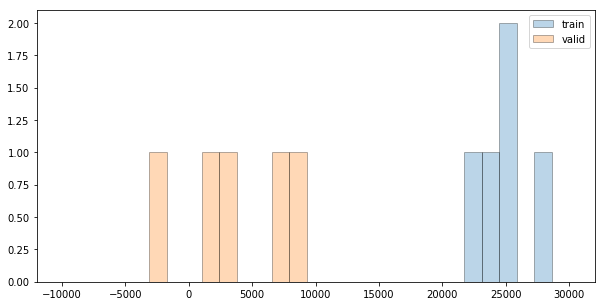

In [31]:
# pick best K pairs from train result and see how good those pairs are in valid
K = 5
train_total_r_ordered = sorted(list(train_total_r_dict.items()), key=lambda x: x[1], reverse=True)
train_total_r_ordered_sliced = train_total_r_ordered[:K]
valid_total_r_sliced = [(x[0], valid_total_r_dict[x[0]]) for x in train_total_r_ordered_sliced]
valid_total_r_corresponding_value = [x[1] for x in valid_total_r_sliced]
train_total_r_sliced_value = [x[1] for x in train_total_r_ordered_sliced]

# see if the model overfits a lot by checking the performace in valid of best K pairs in train
bins = np.linspace(-10000, 30000, 30)
plt.hist(train_total_r_sliced_value, bins, alpha=0.3, label='train')
plt.hist(valid_total_r_corresponding_value, bins, alpha=0.3, label='valid')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)

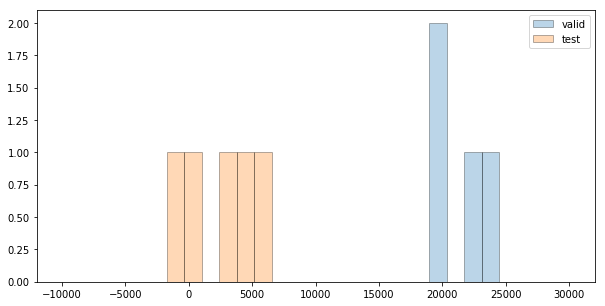

In [26]:
# pick best K pairs from valid result and see how good those pairs are in test
K = 5
valid_total_r_ordered = sorted(list(valid_total_r_dict.items()), key=lambda x: x[1], reverse=True)
valid_total_r_ordered_sliced = valid_total_r_ordered[:K]
test_total_r_sliced = [(x[0], test_total_r_dict[x[0]]) for x in valid_total_r_ordered_sliced]
test_total_r_corresponding_value = [x[1] for x in test_total_r_sliced]
valid_total_r_sliced_value = [x[1] for x in valid_total_r_ordered_sliced]

# see if the model overfits a lot by checking the performace in valid of best K pairs in train
bins = np.linspace(-10000, 30000, 30)
plt.hist(valid_total_r_sliced_value, bins, alpha=0.3, label='valid')
plt.hist(test_total_r_corresponding_value, bins, alpha=0.3, label='test')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)

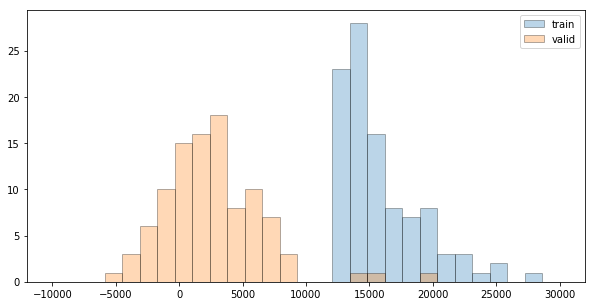

In [32]:
# pick best K pairs from train result and see how good those pairs are in valid
K = 100
train_total_r_ordered = sorted(list(train_total_r_dict.items()), key=lambda x: x[1], reverse=True)
train_total_r_ordered_sliced = train_total_r_ordered[:K]
valid_total_r_sliced = [(x[0], valid_total_r_dict[x[0]]) for x in train_total_r_ordered_sliced]
valid_total_r_corresponding_value = [x[1] for x in valid_total_r_sliced]
train_total_r_sliced_value = [x[1] for x in train_total_r_ordered_sliced]

# see if the model overfits a lot by checking the performace in valid of best K pairs in train
bins = np.linspace(-10000, 30000, 30)
plt.hist(train_total_r_sliced_value, bins, alpha=0.3, label='train')
plt.hist(valid_total_r_corresponding_value, bins, alpha=0.3, label='valid')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)

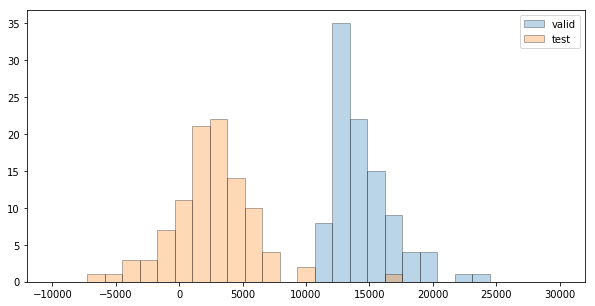

In [33]:
# pick best K pairs from valid result and see how good those pairs are in test
K = 100
valid_total_r_ordered = sorted(list(valid_total_r_dict.items()), key=lambda x: x[1], reverse=True)
valid_total_r_ordered_sliced = valid_total_r_ordered[:K]
test_total_r_sliced = [(x[0], test_total_r_dict[x[0]]) for x in valid_total_r_ordered_sliced]
test_total_r_corresponding_value = [x[1] for x in test_total_r_sliced]
valid_total_r_sliced_value = [x[1] for x in valid_total_r_ordered_sliced]

# see if the model overfits a lot by checking the performace in valid of best K pairs in train
bins = np.linspace(-10000, 30000, 30)
plt.hist(valid_total_r_sliced_value, bins, alpha=0.3, label='valid')
plt.hist(test_total_r_corresponding_value, bins, alpha=0.3, label='test')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 5)